In [10]:
# Clone the repository if needed
# ! git clone -b main https://github.com/chauhang/pytorch-pipeline
import os
cwd = os.getcwd()

os.chdir(os.path.join(cwd, "pytorch-pipeline"))

print(os.getcwd())

/home/ubuntu/Documents/facebook/notebooks/pytorch-pipeline


## Prequisites

#### Following dependent packages needs to be installed before running the build script

1. kfp
2. docker - should be logged in using docker login
3. yq - install using snap - https://github.com/mikefarah/yq


#### ./build.sh takes two arguments

1. path to example - For ex: pytorch_pipeline/examples/cifar10
2. dockerhub username - For ex: shrinathsuresh


In [11]:
! ./build.sh pytorch_pipeline/examples/cifar10 shrinathsuresh

++++ Building component images with tag=13-05-2021-22-10-38.505276
IMAGE TO BUILD: shrinathsuresh/pytorch_pipeline:13-05-2021-22-10-38.505276
Sending build context to Docker daemon  3.708MB
Step 1/9 : FROM pytorch/pytorch:latest
 ---> 5ffed6c83695
Step 2/9 : COPY requirements.txt requirements.txt
 ---> 636826fb6935
Step 3/9 : RUN apt-get update
 ---> Running in 439dae2df968
Get:1 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [24.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic/main amd64 Packages [1344 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [423 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11

## At the end of this step - pytorch_cifar10.yaml file will be generated

In [12]:
import kfp
import json
import os
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler
from pathlib import Path

kfp.__version__

'1.4.0'

## Update AUTH based on the environment

In [13]:
# KFP_URL='istio-ingressgateway.istio-system.svc.cluster.local'
KFP_URL='http://localhost:8080'
AUTH="authservice_session=MTYyMDg4MzA3MHxOd3dBTkZWU1R6WXpWRTVNV0VOUldVTk1UVXROUlRkRVFWRlVORGRGTmxoVk5sbFhRVlpZVmpKVE5FdFVXa2xQU1RKQ1YxQllSVUU9fHLZy5Ig4sSAXjIoMiqDsiZ3awo46HK_cD4OVcdleI0-"
namespace="kubeflow-user-example-com"
client = kfp.Client(host=KFP_URL+"/pipeline", cookies=AUTH)
experiments = client.list_experiments(namespace=namespace)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzutc()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Click on Run Details for navigating to pipeline

In [14]:
run_name = 'pytorch-cifar10'
# Execute pipeline
run = client.run_pipeline(my_experiment.id, run_name, "pytorch_cifar10.yaml")

In [36]:
HOST_LIST = ! kubectl get isvc torchserve -n kubeflow-user-example-com -o jsonpath='{.status.url}'| cut -d "/" -f 3

HOST = HOST_LIST[0]
HOST

'torchserve.kubeflow-user-example-com.example.com'

In [16]:
MODEL_NAME="cifar10"

In [18]:
!curl -v -H "Host: $HOST" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:predict" -d @./pytorch_pipeline/examples/cifar10/input.json > cifar10_prediction_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:predict HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMDg4MzA3MHxOd3dBTkZWU1R6WXpWRTVNV0VOUldVTk1UVXROUlRkRVFWRlVORGRGTmxoVk5sbFhRVlpZVmpKVE5FdFVXa2xQU1RKQ1YxQllSVUU9fHLZy5Ig4sSAXjIoMiqDsiZ3awo46HK_cD4OVcdleI0-
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> 
} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0  67192  0:00:02  0:00:02 --:--:-- 67161* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 150
< content-type: application/json; charset=UTF-8
< date: 

In [19]:
! cat cifar10_prediction_output.json

{"predictions": [{"9": 0.4787258207798004, "1": 0.38499364256858826, "6": 0.09660529345273972, "8": 0.021284256130456924, "0": 0.006451577879488468}]}

In [20]:
!curl -v -H "Host: $HOST" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:explain" -d @./pytorch_pipeline/examples/cifar10/input.json > cifar10_explanation_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/cifar10:explain HTTP/1.1
> Host: torchserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMDg4MzA3MHxOd3dBTkZWU1R6WXpWRTVNV0VOUldVTk1UVXROUlRkRVFWRlVORGRGTmxoVk5sbFhRVlpZVmpKVE5FdFVXa2xQU1RKQ1YxQllSVUU9fHLZy5Ig4sSAXjIoMiqDsiZ3awo46HK_cD4OVcdleI0-
> Content-Length: 148025
> Content-Type: application/x-www-form-urlencoded
> 
} [65536 bytes data]
* We are completely uploaded and fine
100  144k    0     0  100  144k      0   5435  0:00:27  0:00:27 --:--:--     0* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 3479392
< content-type: application/json; charset=UTF-8
< da

In [21]:
! head -5 cifar10_explanation_output.json

{"explanations": [[[[-0.0014064437857968521, 0.002033518409767254, 0.002230971788700838, -0.007865520276820095, 0.015419039552268166, -0.012109596027691545, -0.04128303234511961, -0.022919983142778176, -0.015804812747564255, -0.007944871228645924, -0.03243405038109264, 0.032549942015892695, -0.01572142633408603, -0.03114280272241192, -0.0049712208820424835, 0.010405573935455943, -0.0006446860182190617, -0.015527844268928084, -0.024345928165880305, 0.010141423321424562, -0.007221743801798242, -0.015991606212217548, -0.022446925505242236, 0.00659748992342016, -0.02730875898586734, -0.023456324073974792, 0.005988492737273847, -0.004646542609988188, -0.007018751906336717, -0.004148381306426126, -0.006630899863951036, -0.005601576798209594, -0.008426336803321473, 0.015993117951960407, 0.012806842089490898, 0.012503587596654039, -0.029932342649279527, -0.003027149657410287, 0.016362227559593625, 0.0016065763863835699, -0.010455019187976635, -0.007568245571640977, -0.015631119510906587, 0.000

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
import json
explainations_json = json.loads(open("./cifar10_explanation_output.json", "r").read())
attributions = explainations_json['explanations']

In [23]:
prediction_json = json.loads(open("./cifar10_prediction_output.json", "r").read())
prediction_json["predictions"][0]


{'9': 0.4787258207798004,
 '1': 0.38499364256858826,
 '6': 0.09660529345273972,
 '8': 0.021284256130456924,
 '0': 0.006451577879488468}

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from  PIL import Image
import captum
from captum.attr import visualization as viz
import torchvision.transforms as transforms
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [27]:
#Read the test image
img = Image.open("pytorch_pipeline/examples/cifar10/kitten.png")



In [28]:
#Lets  perform some transformation on the image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transformed_img = transform(img)
input = transformed_img.unsqueeze(0)
input.requires_grad = True

attributions = np.array(attributions)
attributions = attributions.reshape((224,224,3))

In [29]:
original_image = np.transpose((transformed_img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))


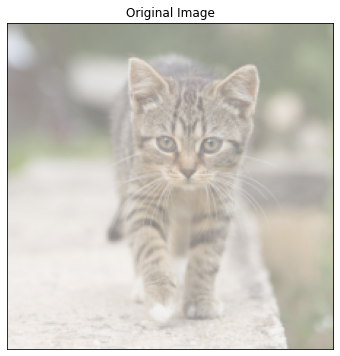

In [30]:
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

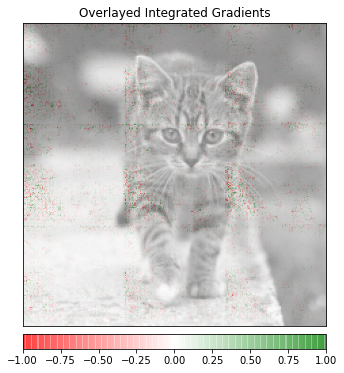

In [31]:
_ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

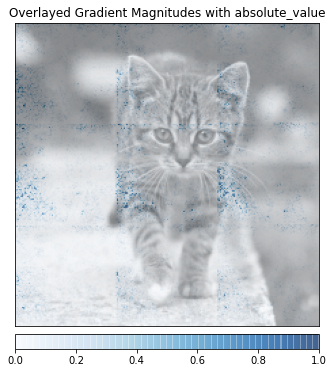

In [33]:
_ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes with absolute_value")

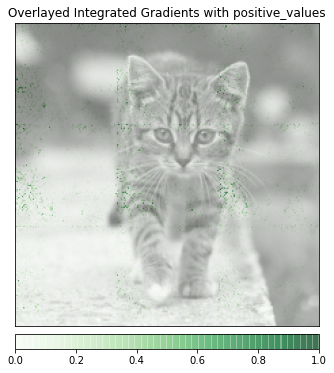

In [34]:
_ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map",sign="positive",
                          show_colorbar=True, title="Overlayed Integrated Gradients with positive_values")

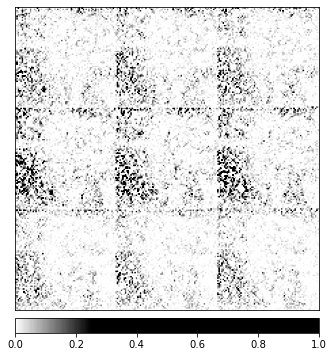

In [35]:
from matplotlib.colors import LinearSegmentedColormap
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(attributions,
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)